In [ ]:
#fetching MNIST handwritten digit dataset

In [9]:
from sklearn.datasets import fetch_openml

In [11]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

X = X.values
print(X.shape)
y = y.astype(int).values
print(y.shape)

(70000, 784)
(70000,)


In [12]:
#normalize the pixel values to the range -1 to 1
X = ((X / 255.) - .5) * 2

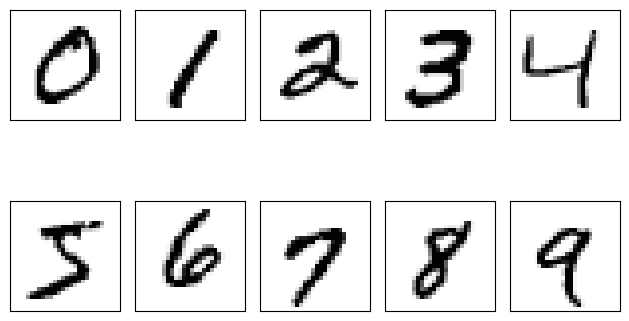

In [15]:
#visualize the example images by reshaping the pizel vectors from our feature matrix into the original 28 x 28 image form
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

In [17]:
#split dataset into training, validation, and test subsets
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

In [34]:
#implementing an Multilayer Perceptron with one hidden layer to classify the digits

In [19]:
#implementing sigmoid activation function and conversion of integer class label arrays into one-hot encoded labels
import numpy as np

##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)
        

In [21]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

In [44]:
#Testing out the model before training
#taking the third sample and its label
sample = X[2]
target = y[2]

In [46]:
#Getting the labels into integer form
int_to_onehot(y, 10)

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [52]:
#feeding the sample forward and getting the model's prediction
model.forward(sample)[1]
np.argmax(model.forward(sample)[1])

8

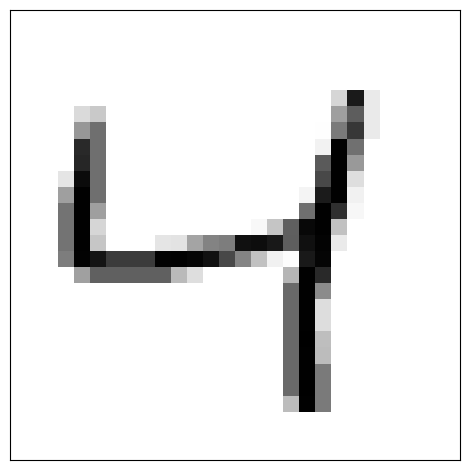

4


In [56]:
#comparing with the label (what the drawn digit actually is)
fig, ax = plt.subplots(sharex=True, sharey=True)
img = sample.reshape(28, 28)
ax.imshow(img, cmap='Greys')

ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

print(target)

In [60]:
#the model predicts 8 where the digit is actually 0. We need training!

In [78]:
#checking out the layers:
print(model.weight_h)
np.size(model.weight_h, 0)

[[-0.10856306  0.09973454  0.02829785 ... -0.20420964 -0.13992339
   0.10576951]
 [-0.06615506 -0.09297116 -0.06925831 ...  0.01314213 -0.07696625
   0.02536767]
 [-0.02262103 -0.16304965  0.01679716 ...  0.04787     0.03738427
   0.00038331]
 ...
 [-0.14622248  0.06477204 -0.0480105  ... -0.11519598 -0.11596581
   0.20556494]
 [ 0.12783801 -0.08216746  0.05149811 ... -0.13146554 -0.23818784
  -0.07527315]
 [ 0.05327355 -0.03507415 -0.02612556 ... -0.03056432 -0.15105755
   0.05010542]]


50

In [82]:
np.size(model.weight_h, 1)

784

In [86]:
#the weight for the hidden layer is a 50 x 784 matrix: the hidden layer has 50 nodes, and there are 784 features to each sample (28 x 28 pizels).

In [90]:
print(model.bias_h)
np.size(model.bias_h, 0)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


50

In [94]:
#the bias is just a 1d vector that gets added in the calculation of net input to the hidden layer.

IndexError: tuple index out of range

In [92]:
#divide dataset into mini-batches for stochastic gradient descent training
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)
